In [482]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, MNIST
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import os

DEVICE = torch.device('cuda')
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [483]:
def switch_to_device(dataset,device=None):
    final_X, final_Y = [], []
    for x, y in dataset:
        final_X.append(x)
        final_Y.append(y)
    X = torch.stack(final_X)
    Y = torch.tensor(final_Y)
    if device is not None:
        X = X.to(device)
        Y = Y.to(device)
    return TensorDataset(X, Y)

In [484]:
def get_Cifar10_dl(batch_size_train=256, batch_size_eval=1024, device=DEVICE):
    transform = transforms.Compose([transforms.ToTensor()])
    
    data_train = CIFAR10('./datasets', train=True, download=True, transform=transform)
    data_train = switch_to_device(data_train, device=device)
    data_train, data_valid = torch.utils.data.random_split(data_train, [45000,5000])
    
    data_test = CIFAR10('./datasets', train=False, download=True, transform=transform)
    data_test = switch_to_device(data_test, device=device)
    
    train_dl = DataLoader(data_train, batch_size=batch_size_train, shuffle=True)
    valid_dl = DataLoader(data_valid, batch_size=batch_size_eval, shuffle=False)
    test_dl = DataLoader(data_test, batch_size=batch_size_eval, shuffle=False)
    
    return train_dl, valid_dl, test_dl

In [485]:
def get_mnist_dl(batch_size_train=1024, batch_size_eval=1024, device=torch.device('cuda')):
    transform = transforms.Compose([transforms.ToTensor()])
    
    data_train = MNIST('./datasets', train=True, download=True, transform=transform)
    data_train = switch_to_device(data_train, device=device)
    data_train, data_valid = torch.utils.data.random_split(data_train, [55000,5000])
    
    data_test = MNIST('./datasets', train=False, download=True, transform=transform)
    data_test = switch_to_device(data_test, device=device)
    
    train_dl = DataLoader(data_train, batch_size=batch_size_train, shuffle=True)
    valid_dl = DataLoader(data_valid, batch_size=batch_size_eval, shuffle=False)
    test_dl = DataLoader(data_test, batch_size=batch_size_eval, shuffle=False)
    
    return train_dl, valid_dl, test_dl

In [486]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [487]:
@torch.no_grad()
def get_acc(model, dl):
  model.eval()
  acc = []
  for X, y in dl:
    #acc.append((torch.sigmoid(model(X)) > 0.5) == y)
    acc.append(torch.argmax(model(X), dim=1) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  model.train()
  return acc.item()

In [488]:
#stats = {'train-loss' : [], 'valid-acc' : [], 'diff_mean' : [], 'diff_variance' : [], 'cosine' : [], 'scale_diff' : []}
def print_stats_full(stats):

  fig, axs= plt.subplots(3, 2, figsize=(7,9), dpi=110)

  axs[0, 0].set_title("ERM loss")
  axs[0, 1].set_title("Valid Acc")
  axs[1, 0].set_title("diff mean")
  axs[1, 1].set_title("diff variance")
  axs[2, 0].set_title("cosine")
  axs[2, 1].set_title("scale_diff")
  #axs[2, 1].set_title("same_sign_perc")


  for i in range(3):
    for j in range(2):
      axs[i, j].set_xlabel("iterations")
      axs[i, j].grid()
  
  itrs = [x[0] for x in stats['train-loss']]
  loss = [x[1] for x in stats['train-loss']]
  axs[0, 0].set_ylim(0.0, max(loss))
  axs[0, 0].plot(itrs, loss)

  itrs = [x[0] for x in stats['valid-acc']]
  acc = [x[1] for x in stats['valid-acc']]
  axs[0, 1].set_ylim(0.0, 1.05)
  axs[0, 1].plot(itrs, acc)

  itrs = [x[0] for x in stats['diff_mean']]
  diff_mean = [x[1].cpu() for x in stats['diff_mean']]
  axs[1, 0].set_ylim(min(diff_mean), max(diff_mean))
  axs[1, 0].plot(itrs, diff_mean)

  itrs = [x[0] for x in stats['diff_mean']]
  diff_variance = [x[1].cpu() for x in stats['diff_mean']]
  axs[1, 1].set_ylim(0.0, max(diff_variance))
  axs[1, 1].plot(itrs, diff_variance)

  itrs = [x[0] for x in stats['cosine']]
  cosine = [x[1].cpu() for x in stats['cosine']]
  axs[2, 0].set_ylim(min(cosine), max(cosine))
  axs[2, 0].plot(itrs, cosine)

  
  itrs = [x[0] for x in stats['scale_diff']]
  scale_diff = [x[1].cpu() for x in stats['scale_diff']]
  axs[2, 1].set_ylim(min(scale_diff), max(scale_diff))
  axs[2, 1].plot(itrs, scale_diff)
  '''
  itrs = [x[0] for x in stats['same_sign_perc']]
  scale_diff = [x[1].cpu() for x in stats['same_sign_perc']]
  axs[2, 1].set_ylim(0, 1)
  axs[2, 1].plot(itrs, scale_diff)
  '''
  plt.tight_layout()
  fig.savefig('testing.jpg', bbox_inches = 'tight')
  print(np.median(cosine))

In [489]:
def print_stats(stats):

  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,3), dpi=110)
  ax1.grid()
  ax2.grid()

  ax1.set_title("ERM loss")
  ax2.set_title("Valid Acc")
  
  ax1.set_xlabel("iterations")
  ax2.set_xlabel("iterations")

  itrs = [x[0] for x in stats['train-loss']]
  loss = [x[1] for x in stats['train-loss']]
  ax1.plot(itrs, loss)

  itrs = [x[0] for x in stats['valid-acc']]
  acc = [x[1] for x in stats['valid-acc']]
  ax2.plot(itrs, acc)

  ax1.set_ylim(0.0, max(loss))
  ax2.set_ylim(0.0, 1.05)
  fig.savefig('testing.jpg', bbox_inches = 'tight')

In [490]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        '''
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        '''
        self.fc = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(4*4*512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU())
        self.fc3= nn.Sequential(
            nn.Linear(1024, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        #out = self.layer9(out)
        '''
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        '''
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [491]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Hardtanh())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Hardtanh(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Hardtanh())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Hardtanh(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(7*7*128, 1024),
            #nn.BatchNorm1d(1024),
            nn.Hardtanh())
        self.fc1 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 256),
            #nn.BatchNorm1d(1024),
            nn.Hardtanh())
        self.fc2 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(256, 64),
            #nn.BatchNorm1d(1024),
            nn.Hardtanh())
        self.fc4= nn.Sequential(
            nn.Linear(64, num_classes))
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc4(out)
        return out

In [492]:
class Batch_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(Batch_CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Hardtanh())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Hardtanh(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Hardtanh())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Hardtanh(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(7*7*128, 1024),
            nn.BatchNorm1d(1024),
            nn.Hardtanh())
        self.fc1 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Hardtanh())
        self.fc2 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Hardtanh())
        self.fc4= nn.Sequential(
            nn.Linear(1024, num_classes))
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc4(out)
        return out

In [493]:
class small_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(small_CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(2),
            nn.Hardtanh())
        self.layer2 = nn.Sequential(
            nn.Conv2d(2, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.Hardtanh(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.Hardtanh())
        self.layer4 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.Hardtanh(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(7*7*8, 1024),
            nn.BatchNorm1d(1024),
            nn.Hardtanh())
        self.fc1 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Hardtanh())
        self.fc2 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Hardtanh())
        self.fc3 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Hardtanh())
        self.fc4= nn.Sequential(
            nn.Linear(1024, num_classes))
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

In [494]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.Hardtanh())
        self.fc1 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.Hardtanh())
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.Hardtanh())
        self.fc4= nn.Sequential(
            nn.Linear(1024, num_classes))
    
    def forward(self, x):
        out = x.reshape(x.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc4(out)
        return out

In [495]:
def cal_proj_matrix(A):
    return A @ torch.linalg.pinv(A.T @ A) @ A.T

In [496]:
def Normalize(input):
    mean = torch.mean(input, dim=1).view(-1, 1)
    std = torch.std(input, dim=1).view(-1, 1)
    return (input - mean)/std

In [497]:
'''
                        if len(parameters.shape) == 2 and use_linear_projection:
                            input = layer_inputs[name_module[name[:name.find('.', name.find('.') + 1)]]]
                            weight = torch.rand(num_dir, 1, input.shape[0], device = DEVICE)
                            weight = weight/(weight.sum(dim = 2).view(num_dir,1,1))
                            input = input.T
                            input_sample = input * weight
                            input_sample = torch.sum(input_sample, dim = 2).view(num_dir, 1, -1)
                            v = torch.randn(num_dir, parameters.shape[0], device = DEVICE).view(num_dir, parameters.shape[0], 1)
                            v = (v @ input_sample).view(num_dir, -1)
                            #v = Normalize(v)
                            #v = v/(v.norm(dim = 1).view(num_dir, 1)) * (v.shape[1]**(1/2))
                            #v = v/(v.norm(dim = 1).view(num_dir, 1)) * ((parameters.shape[0]*parameters.shape[1])**(1/2))
                        '''

"\n                        if len(parameters.shape) == 2 and use_linear_projection:\n                            input = layer_inputs[name_module[name[:name.find('.', name.find('.') + 1)]]]\n                            weight = torch.rand(num_dir, 1, input.shape[0], device = DEVICE)\n                            weight = weight/(weight.sum(dim = 2).view(num_dir,1,1))\n                            input = input.T\n                            input_sample = input * weight\n                            input_sample = torch.sum(input_sample, dim = 2).view(num_dir, 1, -1)\n                            v = torch.randn(num_dir, parameters.shape[0], device = DEVICE).view(num_dir, parameters.shape[0], 1)\n                            v = (v @ input_sample).view(num_dir, -1)\n                            #v = Normalize(v)\n                            #v = v/(v.norm(dim = 1).view(num_dir, 1)) * (v.shape[1]**(1/2))\n                            #v = v/(v.norm(dim = 1).view(num_dir, 1)) * ((parameters.sha

In [498]:
def run_experiment(model, opt, scheduler, criterion, train_dl, valid_dl, test_dl, max_epochs, use_forward_grad, num_dir, use_linear_projection, use_cnn_projection, version):
    itr = -1
    stats = {'train-loss' : [], 'valid-acc' : [], 'diff_mean' : [], 'diff_variance' : [], 'cosine' : [], 'scale_diff' : [], 'same_sign_perc' : []}

    if use_forward_grad:
        random_dir = {}
        for i, p in enumerate(model.parameters()):
            random_dir[i] = 0
    
    if use_linear_projection or use_cnn_projection:
        name_module = {}
        layer_inputs = {}
        def hook(mod, input):
            layer_inputs[mod] = input[0]
        for module in model.modules():
            module.register_forward_pre_hook(hook)
        for name, module in model.named_modules():
            name_module[name] = module

    for epoch in range(max_epochs):
        for x, y in train_dl:
            #print(itr)
            itr += 1
            opt.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()

            if use_forward_grad:
                with torch.no_grad():
                    da = torch.zeros((num_dir, 1), device=DEVICE)

                    for i, (name, parameters) in enumerate(model.named_parameters()):
                        g = parameters.grad.view(-1)
                    
                        
                        if len(parameters.shape) == 2 and use_linear_projection:
                            have_next_linear = False
                            projected_space = 0
                            input = layer_inputs[name_module[name[:name.find('.', name.find('.') + 1)]]]
                            #input = torch.randn(input.shape, device = DEVICE)
                            if version == 0:
                                input_sample = torch.randn(num_dir, 1, parameters.shape[1], device = DEVICE)
                            elif version == 1:
                                projection_matrix = cal_proj_matrix(input.T)
                                input_sample = torch.randn(num_dir, parameters.shape[1], device = DEVICE).view(num_dir, parameters.shape[1], 1)
                                input_sample = (projection_matrix @ input_sample).view(num_dir, 1, -1)

                            '''
                            for j, (name_next, parameters_next) in enumerate(model.named_parameters()):
                                if j > i and len(parameters_next.shape) == 2:
                                    have_next_linear = True
                                    projected_space = cal_proj_matrix(parameters_next.T)                                    
                                if have_next_linear:
                                    break

                            if have_next_linear:
                                r_next = torch.randn(num_dir, parameters.shape[0], device = DEVICE).view(num_dir, parameters.shape[0], 1)
                                #v = (weight_next.T @ r_next)#.view(num_dir, -1)
                                v = projected_space @ r_next
                            else:
                                v = torch.randn(num_dir, parameters.shape[0], device = DEVICE).view(num_dir, parameters.shape[0], 1)
                            '''
                            if version != 2:
                                v = torch.randn(num_dir, parameters.shape[0], device = DEVICE).view(num_dir, parameters.shape[0], 1)
                                v = (v @ input_sample).view(num_dir, -1)
                                v = v/(v.norm(dim = 1, keepdim = True)) * ((parameters.shape[0]*parameters.shape[1])**0.5)
                            else:
                                v = torch.randn(num_dir, input.shape[0], parameters.shape[0], device = DEVICE)
                                #input = input/(input.norm(dim = 1, keepdim=True))
                                v = (input.T @ v)#/input.shape[0]
                                v = v.view(num_dir, -1)
                                v = v/(v.norm(dim = 1, keepdim = True)) * ((parameters.shape[0]*parameters.shape[1])**0.5)
                            #scale = (projection_matrix**2).sum(dim = 1).view(-1).repeat(parameters.shape[0])
                            random_dir[i] = v#/(scale)**0.5#*(input.shape[1]/input.shape[0])

                        elif len(parameters.shape) == 4 and use_cnn_projection:
                            input = layer_inputs[name_module[name[:name.find('.', name.find('.') + 1)]]]
                            shape_input = input.shape
                            input = input.view(input.shape[0], -1)
                            projection_matrix = cal_proj_matrix(input.T)
                            input_sample = torch.randn(num_dir, input.shape[1], device = DEVICE).view(num_dir, input.shape[1], 1)
                            #input_sample = input_sample.view(num_dir, shape_input[1], shape_input[2], shape_input[3])
                            input_sample = (projection_matrix @ input_sample).view(num_dir, shape_input[1], shape_input[2], shape_input[3])
                            output_sample = torch.randn(num_dir, parameters.shape[0], shape_input[2], shape_input[3], device = DEVICE)
                            v = torch.zeros(num_dir, parameters.shape[0]*parameters.shape[1], parameters.shape[2], parameters.shape[3], device = DEVICE)
                            for n in range(num_dir):
                                #for f in range(parameters.shape[0]):
                                    #v[n][f] = torch.nn.functional.conv2d(input_sample[n], output_sample[n][f].unsqueeze(0).unsqueeze(0).expand(parameters.shape[1], parameters.shape[1],shape_input[2], shape_input[3]), stride=1, padding=1)
                                v[n] = torch.nn.functional.conv2d(input_sample[n], output_sample[n].unsqueeze(1).unsqueeze(2).expand(parameters.shape[0], parameters.shape[1], parameters.shape[1],shape_input[2], shape_input[3]).reshape(parameters.shape[0]*parameters.shape[1], parameters.shape[1],shape_input[2], shape_input[3]), stride=1, padding=1)
                            v = v.view(num_dir, -1)
                            v = v/(v.norm(dim = 1).view(num_dir, 1)) * ((parameters.shape[0]*parameters.shape[1]*parameters.shape[2]*parameters.shape[3])**(1/2))
                            random_dir[i] = v

                        else:
                            v = torch.randn(num_dir, len(g), device=DEVICE)
                            random_dir[i] = v

                        '''
                        if len(parameters.shape) == 2 and use_linear_projection:
                            input = layer_inputs[name_module[name[:name.find('.', name.find('.') + 1)]]] #input : b*input_dim
                            input = input/(input.norm(dim = 1, keepdim=True))
                            #v = torch.randn(num_dir, 1, parameters.shape[0], device = DEVICE).expand(num_dir, input.shape[0], parameters.shape[0])
                            v = torch.randn(num_dir, input.shape[0], parameters.shape[0], device = DEVICE)
                            v = (input.T @ v)#/input.shape[0]
                            v = v.view(num_dir, -1)

                        elif len(parameters.shape) == 4 and use_cnn_projection:
                            input = layer_inputs[name_module[name[:name.find('.', name.find('.') + 1)]]] #input: b*C*H*W
                            batch_size = input.shape[0]
                            input_channel = input.shape[1]
                            H = input.shape[2]
                            W = input.shape[3]
                            kH = parameters.shape[2]
                            kW = parameters.shape[3]
                            output_channel = parameters.shape[0]
                            output_sample = torch.randn(num_dir, output_channel, H, W, device = DEVICE)
                            v = torch.zeros(num_dir, input_channel*output_channel, kH, kW, device = DEVICE)
                            for n in range(num_dir):
                                v[n] = torch.nn.functional.conv2d(input, output_sample[n].unsqueeze(1).unsqueeze(2).expand(output_channel, input_channel, input_channel, H, W).reshape(output_channel*input_channel, input_channel, H, W), stride=1, padding=1).mean(dim = 0)
                            v = v.view(num_dir, -1)
                        '''    
                        da += (v @ g).view(num_dir, 1)

                    estimation = torch.tensor([]).to(DEVICE)
                    true_gradient = torch.tensor([]).to(DEVICE)
                    for i, p in enumerate(model.parameters()):
                        g = da * random_dir[i]
                        true_gradient = torch.cat((true_gradient, p.grad.view(-1)), dim = 0)
                        estimation = torch.cat((estimation, torch.mean(g, dim = 0)), dim = 0)
                        p.grad = torch.mean(g, dim = 0).view(p.grad.shape)
            
            opt.step()
            scheduler.step()
            #torch.cuda.empty_cache()
            stats['train-loss'].append((itr, loss.item()))

            if use_forward_grad:
                same_sign_perc = torch.sum(true_gradient.sign() == estimation.sign())/torch.numel(true_gradient)
                scale_true_gradient = true_gradient.norm()
                scale_estimation = estimation.norm()
                stats['diff_mean'].append((itr, torch.mean(estimation - true_gradient)))
                stats['diff_variance'].append((itr, torch.var(estimation - true_gradient)))
                stats['cosine'].append((itr, torch.sum(true_gradient*estimation)/(scale_true_gradient*scale_estimation)))
                stats['scale_diff'].append((itr, scale_estimation - scale_true_gradient))
                stats['same_sign_perc'].append((itr, same_sign_perc))
            
            if itr % 100 == 0:
                #print(same_sign_perc)
                valid_acc = get_acc(model, valid_dl)
                stats['valid-acc'].append((itr, valid_acc))
                s = f"{epoch}:{itr} [train] loss:{loss.item():.3f}, [valid] acc:{valid_acc:.3f}"
                print(s)

    test_acc = get_acc(model, test_dl)
    print(f"[test] acc:{test_acc:.3f}")

    return stats

    


In [499]:
#model= VGG16().to(DEVICE)
model = Batch_CNN().to(DEVICE)
#model = CNN().to(DEVICE)
#model = small_CNN().to(DEVICE)
#model = LeNet().to(DEVICE)
print(count_parameters(model))

train_batch_size = 256
test_batch_size = 1024

train_dl, valid_dl, test_dl = get_mnist_dl(train_batch_size, test_batch_size, device = DEVICE)
#train_dl, valid_dl, test_dl = get_Cifar10_dl(train_batch_size, test_batch_size, device = DEVICE)

opt = torch.optim.SGD(model.parameters(), lr = 1e-4)
#opt = torch.optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=2000, gamma=0.5)
criterion =nn.CrossEntropyLoss()
max_epochs = 20

use_forward_grad = True
num_dir = 1
use_linear_projection = True
use_cnn_projection = False
version = 1

8798922


0:0 [train] loss:2.369, [valid] acc:0.142
0:100 [train] loss:1.673, [valid] acc:0.395
0:200 [train] loss:1.465, [valid] acc:0.512
1:300 [train] loss:1.348, [valid] acc:0.557
1:400 [train] loss:1.211, [valid] acc:0.617
2:500 [train] loss:1.139, [valid] acc:0.639
2:600 [train] loss:1.137, [valid] acc:0.653
3:700 [train] loss:1.026, [valid] acc:0.668
3:800 [train] loss:0.963, [valid] acc:0.700
4:900 [train] loss:0.950, [valid] acc:0.718
4:1000 [train] loss:0.922, [valid] acc:0.719
5:1100 [train] loss:0.895, [valid] acc:0.741
5:1200 [train] loss:0.887, [valid] acc:0.754
6:1300 [train] loss:0.840, [valid] acc:0.766
6:1400 [train] loss:0.722, [valid] acc:0.765
6:1500 [train] loss:0.763, [valid] acc:0.794
7:1600 [train] loss:0.710, [valid] acc:0.815
7:1700 [train] loss:0.669, [valid] acc:0.809
8:1800 [train] loss:0.672, [valid] acc:0.813
8:1900 [train] loss:0.666, [valid] acc:0.816
9:2000 [train] loss:0.611, [valid] acc:0.824
9:2100 [train] loss:0.668, [valid] acc:0.832
10:2200 [train] loss:0

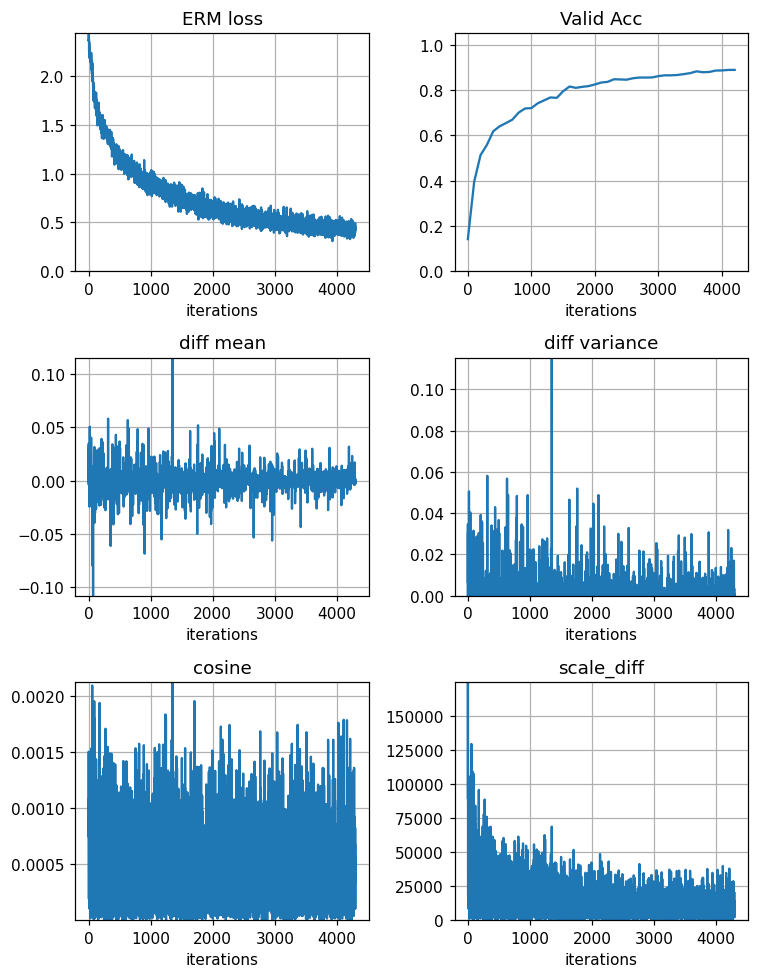

: 

In [500]:
stats = run_experiment(model, opt, scheduler, criterion, train_dl, valid_dl, test_dl, max_epochs, use_forward_grad, num_dir, use_linear_projection, use_cnn_projection, version)
if use_forward_grad:
    print_stats_full(stats)
else:
    print_stats(stats)